**Time series forecasting with a statistical ensemble model : an application for global goods trade volume prediction**



# Import librairies

In [231]:
from datetime import timedelta

from multiprocessing import cpu_count

import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from scipy import stats

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from statsforecast import StatsForecast
from statsforecast.models import (
        AutoETS, AutoCES,AutoARIMA,
        DynamicOptimizedTheta
)

from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from sklearn.preprocessing import StandardScaler

# Load data

In [232]:
Y_df = pd.read_excel("D:/Research/Papers/Global trade volume forecasting/data.xlsx")
Y_df["Unnamed: 0"] = pd.to_datetime(Y_df["Unnamed: 0"], format="%YM%m")
Y_df.rename(columns={"Unnamed: 0":"date"},inplace=True)
Y_df.set_index("date",inplace=True)

# Exploratory data analysis & feature engineering

In [233]:
Y_df.describe()

,world_expo,world_impo
count,7.560000e+02,7.560000e+02
mean,5.512778e+05,5.611418e+05
std,5.960761e+05,6.023006e+05
min,4.460728e+03,4.414615e+03
25%,5.664640e+04,6.441776e+04
50%,2.871899e+05,2.968332e+05
75%,1.033335e+06,1.053721e+06
max,2.172644e+06,2.222219e+06


In [234]:
Y_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 756 entries, 1960-01-01 to 2022-12-01
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   world_expo  756 non-null    float64
 1   world_impo  756 non-null    float64
dtypes: float64(2)
memory usage: 17.7 KB


In [235]:
# Create a complete date range from january 1960 to december 2022
complete_date_range = pd.date_range(start=Y_df.index.min(), end=Y_df.index.max(), freq='MS')

# Check if all dates in the full range are in our Y_df DataFrame's index
missing_dates = complete_date_range[~complete_date_range.isin(Y_df.index)]

if missing_dates.empty:
    print("There is no missing date.")
else:
    print(f"There is {missing_dates.size} missing date.")
    print(missing_dates)

There is no missing date.


We have neither a missing value nor a negative value.

## Calculate trade volume

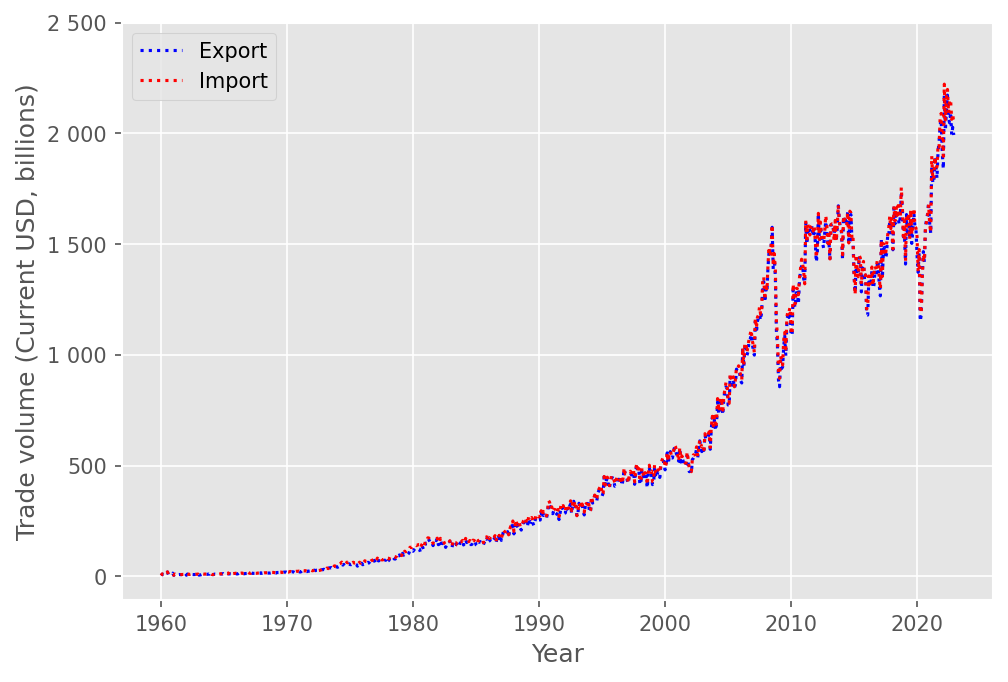

In [236]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(7.5,5),dpi=150)
plt.plot(Y_df.index, Y_df["world_expo"], linestyle='dotted', color='b', label="Export")
plt.plot(Y_df.index, Y_df["world_impo"], linestyle='dotted', color='r', label="Import")
plt.xlabel("Year", fontsize=12)
plt.ylabel("Trade volume (Current USD, billions)", fontsize=12)
plt.yticks(ticks=list(range(0, 3000000, 500000)), labels=["0", "500", "1 000", "1 500", "2 000", "2 500"])
plt.legend()
plt.show()

Let's calculate the Pearson correlation coefficient to gain insight into the relationship between global goods exports and imports : 

In [237]:
corr_coef = np.corrcoef(Y_df["world_expo"], Y_df["world_impo"])[0, 1]

print("The Pearson correlation coefficient is :", corr_coef)

The Pearson correlation coefficient is : 0.9998253022930155


Let's ascertain the global trade volume by computing the mean of worldwide exports and imports of goods :

In [238]:
Y_df["trade_volume"] = (Y_df["world_expo"] + Y_df["world_impo"]) / 2

## Statistical distribution

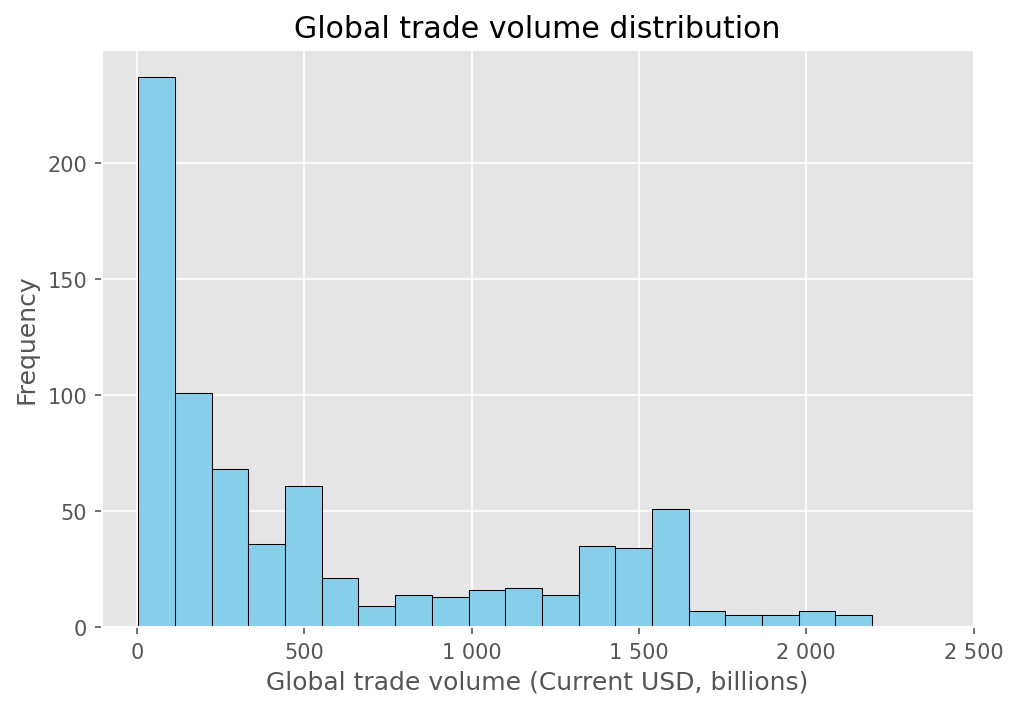

In [239]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(7.5,5),dpi=150)
Y_df['trade_volume'].plot(kind='hist', bins=20, color='skyblue', edgecolor='black')
plt.title('Global trade volume distribution')
plt.xticks(ticks=list(range(0, 3000000, 500000)), labels=["0", "500", "1 000", "1 500", "2 000", "2 500"])
plt.xlabel('Global trade volume (Current USD, billions)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

We can visualize that our series is not Gaussian. Let's confirm it by performing the Shapiro-Wilk test for normality :

Null hypothesis (H0): The population is normally distributed.

Alternative hypothesis (H1): The population is not normally distributed.

In [240]:
# Build the test
shapiro_test = stats.shapiro(Y_df['trade_volume'])

# The test returns a tuple containing two values: the W statistic and the p-value.
W, p = shapiro_test

print(f"W Statistic : {W}")
print(f"p-value : {p}")

W Statistic : 0.8215363025665283
p-value : 3.754767260264349e-28


We can confirm that our series is not Gaussian.

## Outliers detection

Let's utilize boxplot to visually inspect our data for any outliers:

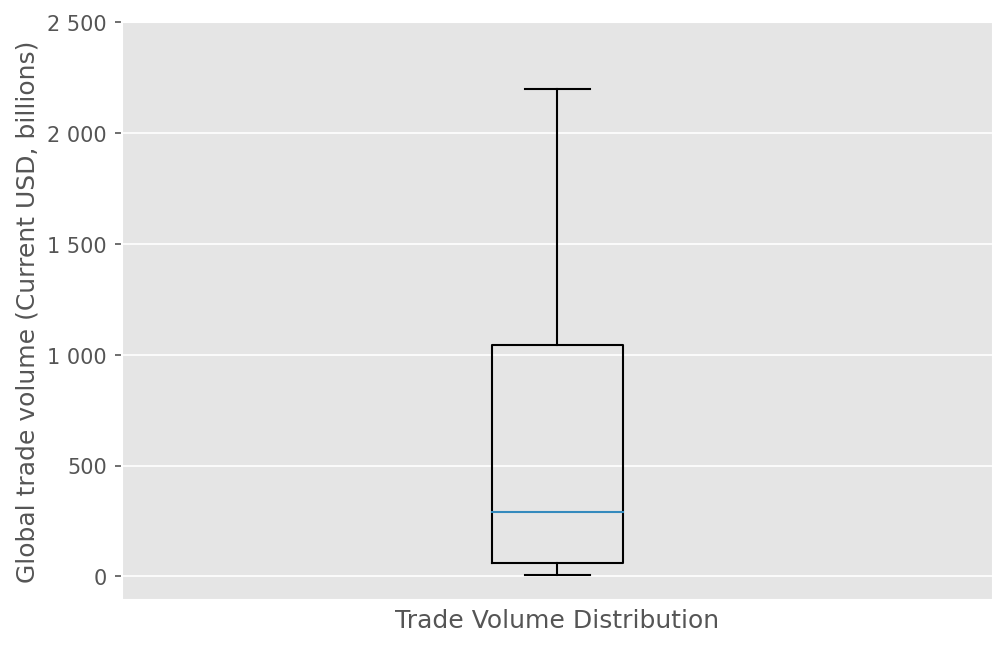

In [241]:
plt.style.use('ggplot')
fig,ax=plt.subplots(figsize=(7.5,5),dpi=150)
plt.boxplot(Y_df['trade_volume'])
plt.xlabel('Trade Volume Distribution')
plt.xticks(ticks=[])
plt.yticks(ticks=list(range(0, 3000000, 500000)), labels=["0", "500", "1 000", "1 500", "2 000", "2 500"])
plt.ylabel('Global trade volume (Current USD, billions)')
plt.show()

Based on initial observation, there do not appear to be any outliers. Let's confirm this using the interquartile range method :

In [242]:
def detect_outliers_iqr(data):
    # Calculate Q1, Q3 and IQR
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1

    # Define the upper and lower bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Detect outliers
    outliers = [x for x in data if x < lower_bound or x > upper_bound]

    return outliers

In [243]:
outliers = detect_outliers_iqr(Y_df['trade_volume'])
outliers

[]

There are no outliers present in our series.

## Time series components

Let's analyze the components of our time series data by decomposing it :

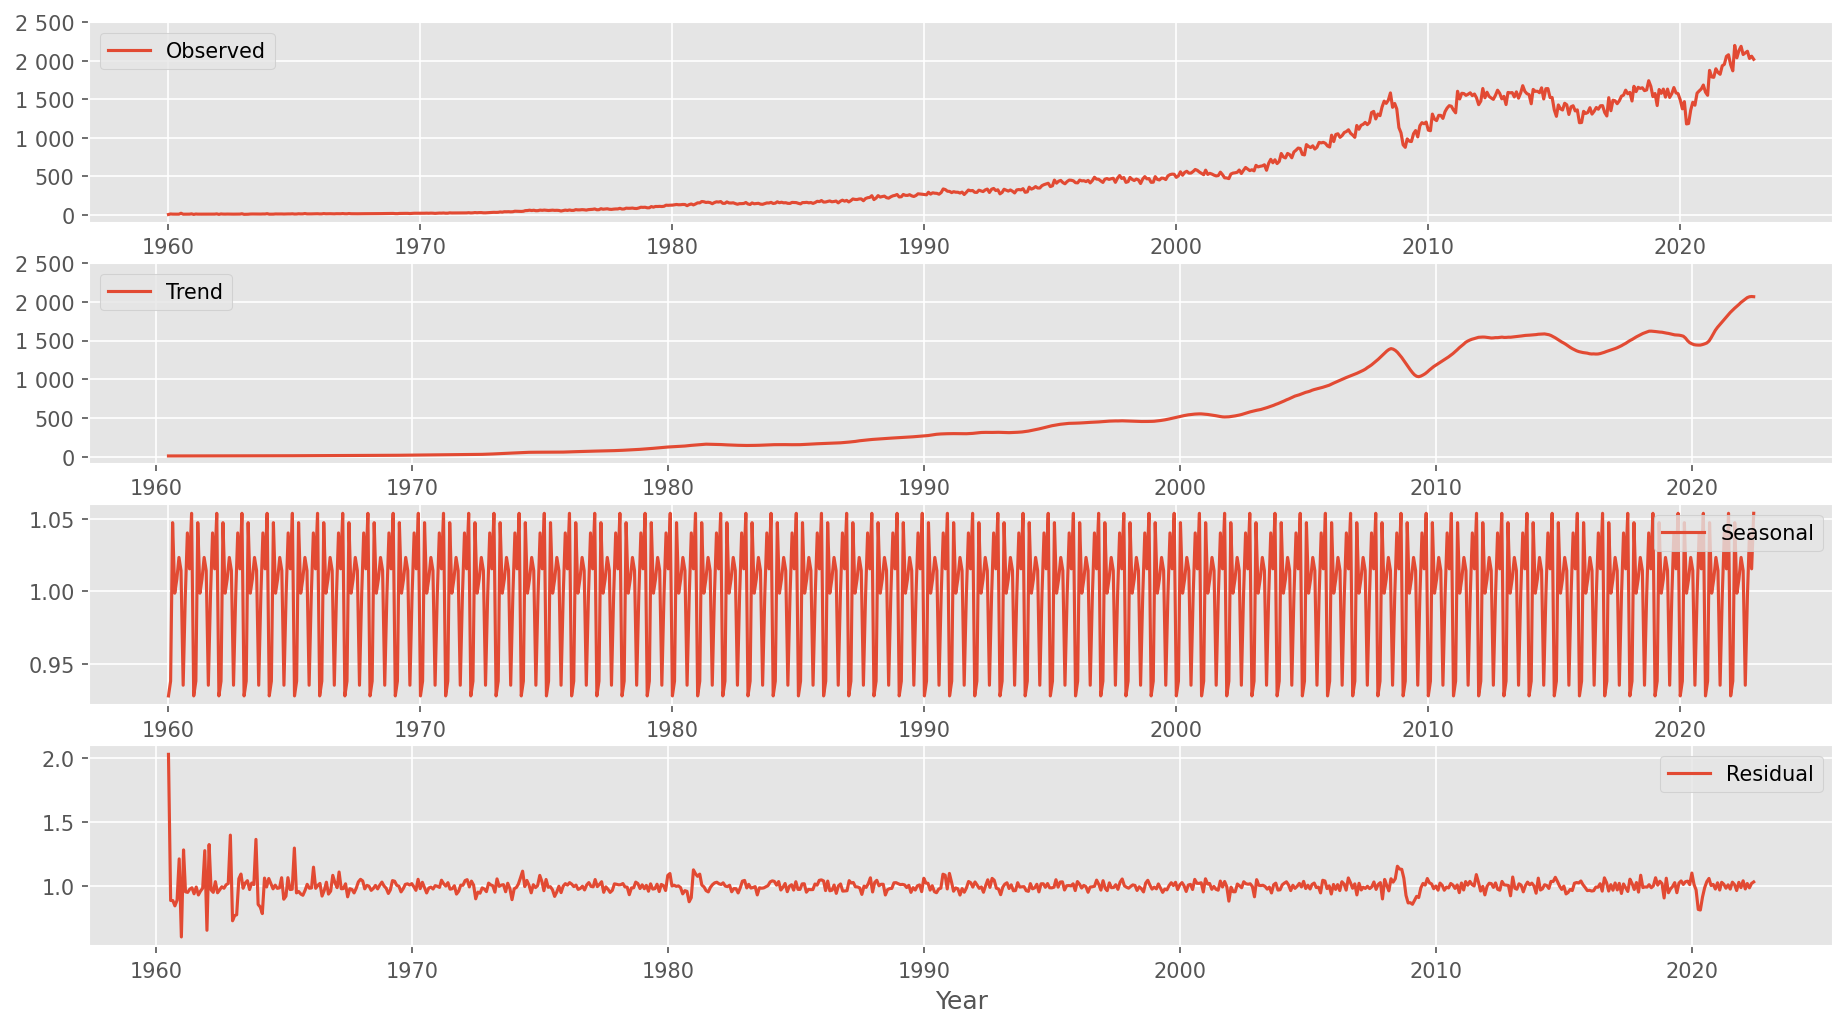

In [244]:
plt.style.use('ggplot')

# Time series decomposition
result = seasonal_decompose(Y_df["trade_volume"], model='multiplicative')

# Displaying the components
plt.figure(figsize=(15, 8),dpi=150)

plt.subplot(411)
plt.plot(result.observed, label='Observed')
plt.yticks(ticks=list(range(0, 3000000, 500000)), labels=["0", "500", "1 000", "1 500", "2 000", "2 500"])
plt.legend()

plt.subplot(412)
plt.plot(result.trend, label='Trend')
plt.yticks(ticks=list(range(0, 3000000, 500000)), labels=["0", "500", "1 000", "1 500", "2 000", "2 500"])
plt.legend()

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal')
plt.legend()

plt.subplot(414)
plt.plot(result.resid, label='Residual')
plt.legend()

plt.xlabel('Year')
plt.show()

We can see that the global volume of goods trade has been on an upward trend since 1960.

Let's have a more detailed perspective by narrowing down the observation period :

<Axes: xlabel='date'>

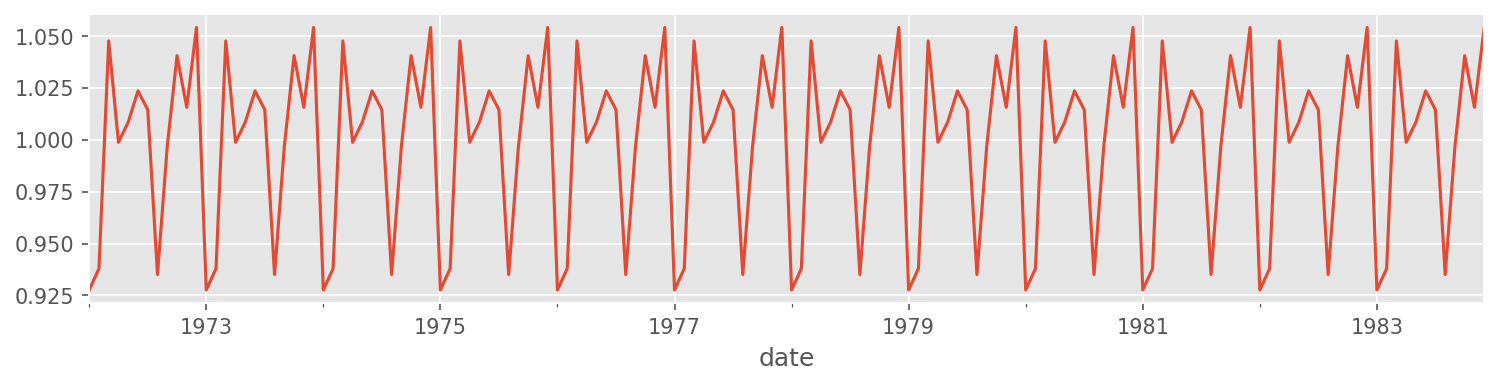

In [245]:
plt.style.use('ggplot')
plt.figure(figsize=(12,2.5),dpi=150)
seasonal_decompose(Y_df["trade_volume"], model='multiplicative').seasonal[144:288].plot()

<Axes: xlabel='date'>

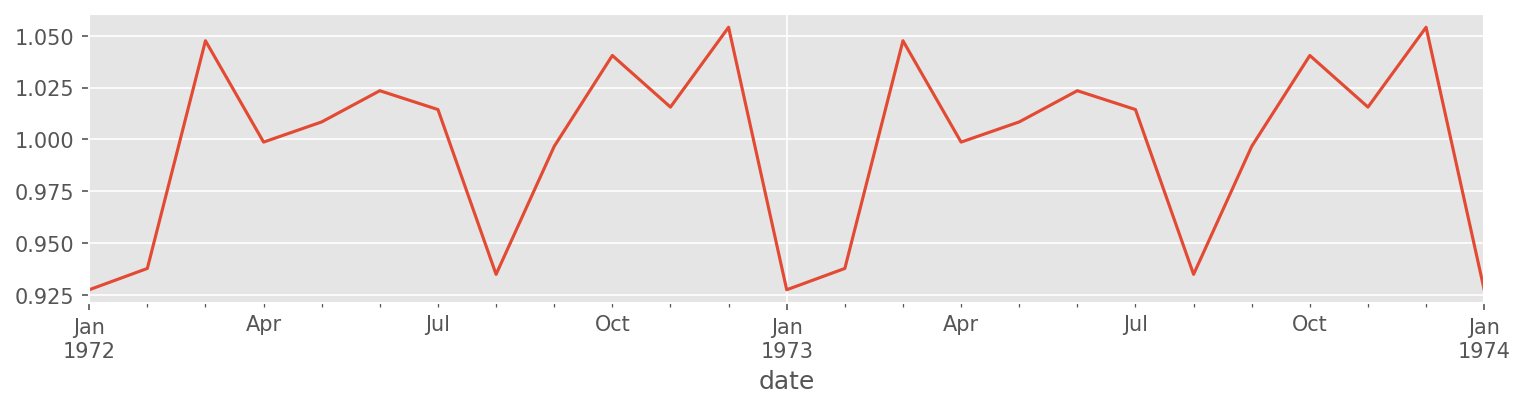

In [246]:
plt.style.use('ggplot')
plt.figure(figsize=(12, 2.5),dpi=150)
seasonal_decompose(Y_df["trade_volume"], model='multiplicative').seasonal[144:169].plot()

The graphs above exhibit a clear yearly seasonality pattern.

Now, let's validate our assumption regarding stationarity through decomposition using statistical test (Augmented Dickey-Fuller Test (ADF Test) ):

The null (H0) and alternative (H1) hypotheses of this test are:

H0: The series has a unit root (a value of a = 1), indicating that the series is non-stationary.

H1: The series does not have a unit root, indicating that the series is stationary.

In [247]:
# run the test
result = adfuller(Y_df["trade_volume"])

# print results
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print(f'Critical Values: {key}, {value}')

ADF Statistic: 1.1879579678180996
p-value: 0.995901618971927
Critical Values: 1%, -3.4392661055744767
Critical Values: 5%, -2.86547495466493
Critical Values: 10%, -2.56886540295664


We have confirmed that the series is non-stationary. 

Now, let's proceed to make it stationary.

Despite the presence of an exponential trend, applying a logarithmic transformation does not achieve stationarity; instead, it merely compresses the scale of the series without rendering it stationary. Therefore, let's employ the differencing method.

In [248]:
Y_df["trade_volume_statio"] = Y_df["trade_volume"].diff()

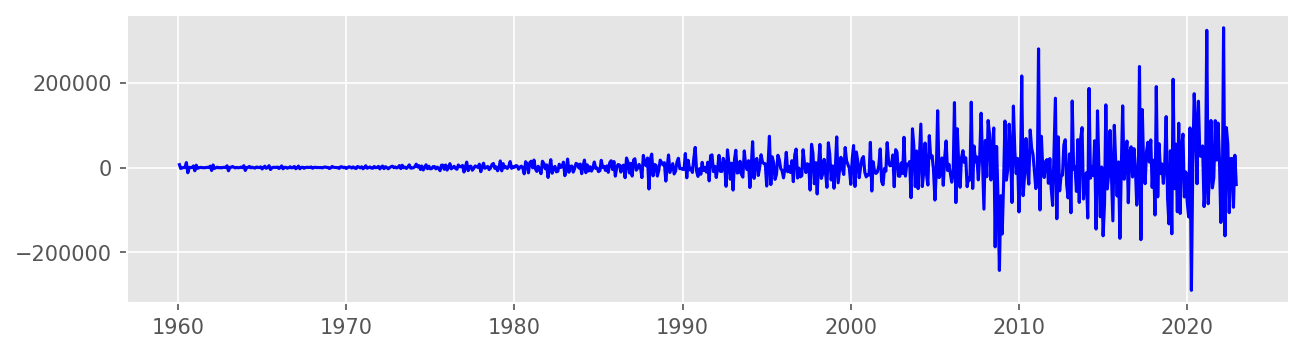

In [249]:
plt.style.use('ggplot')
plt.figure(figsize=(10, 2.5),dpi=150)
plt.plot(Y_df.index, Y_df["trade_volume_statio"],color='b',label = "Export")

Please Note: The use of stationary data is solely for understanding our dataset. However, for our forecasting purposes, we will revert to default data as our models are now equipped to handle it effectively.

## Fetaure scaling

In [250]:
# Initialize a StandardScaler object
scaler = StandardScaler()

# Fitting and transforming with StandardScaler
Y_df['trade_volume'] = scaler.fit_transform(Y_df[['trade_volume']])
Y_df

,world_expo,world_impo,trade_volume,trade_volume_statio
date,,,,
1960-01-01,4.460728e+03,4.414615e+03,-0.921516,NaN
1960-02-01,1.077233e+04,1.179932e+04,-0.910079,6848.150000
1960-03-01,8.879228e+03,9.483650e+03,-0.913593,-2104.382500
1960-04-01,8.207328e+03,8.777070e+03,-0.914744,-689.240000
1960-05-01,8.477928e+03,8.971800e+03,-0.914356,232.665000
...,...,...,...,...
2022-08-01,2.047739e+06,2.152595e+06,2.578567,20946.579823
2022-09-01,2.096082e+06,2.147257e+06,2.614477,21501.948784
2022-10-01,1.993195e+06,2.063197e+06,2.458367,-93473.396335


## Preparing data for prediction

In [251]:
Y_df.reset_index(inplace=True)
Y_df = Y_df[['date', 'trade_volume']]
Y_df.rename(columns={"date":"ds","trade_volume":"y"},inplace=True)
Y_df["unique_id"] = "trade"
Y_df

C:\Users\fitah\AppData\Local\Temp\ipykernel_23428\4158487506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_df.rename(columns={"date":"ds","trade_volume":"y"},inplace=True)
C:\Users\fitah\AppData\Local\Temp\ipykernel_23428\4158487506.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_df["unique_id"] = "trade"


,ds,y,unique_id
0,1960-01-01,-0.921516,trade
1,1960-02-01,-0.910079,trade
2,1960-03-01,-0.913593,trade
3,1960-04-01,-0.914744,trade
4,1960-05-01,-0.914356,trade
...,...,...,...
751,2022-08-01,2.578567,trade
752,2022-09-01,2.614477,trade
753,2022-10-01,2.458367,trade
754,2022-11-01,2.506954,trade


Let's initialize temporal variables :

In [252]:
frequency = "M" # we have a monthly data
seasonality = 12 # we excpected an annual seasonality (ref. above)
horizon = 12 # we would like to forecast the next 12 months trade volume (next 1 year)

Create the test set :

In [253]:
test = Y_df.groupby('unique_id').tail(horizon)
test

,ds,y,unique_id
744,2022-01-01,2.322525,trade
745,2022-02-01,2.190450,trade
746,2022-03-01,2.740425,trade
747,2022-04-01,2.471942,trade
748,2022-05-01,2.629228,trade
749,2022-06-01,2.721027,trade
750,2022-07-01,2.543584,trade
751,2022-08-01,2.578567,trade
752,2022-09-01,2.614477,trade
753,2022-10-01,2.458367,trade


Create the train set :

In [254]:
train = Y_df.drop(test.index)
train = train.iloc[1:]
train

,ds,y,unique_id
1,1960-02-01,-0.910079,trade
2,1960-03-01,-0.913593,trade
3,1960-04-01,-0.914744,trade
4,1960-05-01,-0.914356,trade
5,1960-06-01,-0.914208,trade
...,...,...,...
739,2021-08-01,2.115295,trade
740,2021-09-01,2.299969,trade
741,2021-10-01,2.329512,trade
742,2021-11-01,2.504770,trade


# Modeling

## Build the model & prediction

Let's initialize each statistics models :

In [255]:
models = [
        AutoARIMA(season_length=seasonality),
        AutoCES(season_length=seasonality),
        AutoETS(season_length=seasonality),
        DynamicOptimizedTheta(season_length=seasonality)
    ]

Run the forecasting :

In [256]:
fcst = StatsForecast(df=train, models=models, freq=frequency, n_jobs=cpu_count())
forecasts = fcst.forecast(h=horizon)

c:\Users\fitah\anaconda3\Lib\site-packages\statsforecast\core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(
c:\Users\fitah\anaconda3\Lib\site-packages\statsforecast\core.py:399: FutureWarning: The `df` argument of the StatsForecast constructor as well as reusing stored dfs from other methods is deprecated and will raise an error in a future version. Please provide the `df` argument to the corresponding method instead, e.g. fit/forecast.
  warnings.warn(


c:\Users\fitah\anaconda3\Lib\site-packages\statsforecast\core.py:417: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


In [257]:
# make date continue
forecasts["ds"] = forecasts["ds"] + timedelta (days=1)
forecasts

,ds,AutoARIMA,CES,AutoETS,DynamicOptimizedTheta
unique_id,,,,,
trade,2022-01-01,2.455005,2.394071,2.382333,2.465075
trade,2022-02-01,2.416299,2.305947,2.260407,2.442636
trade,2022-03-01,2.718328,2.658675,2.629411,2.553830
trade,2022-04-01,2.638787,2.451522,2.460510,2.509658
trade,2022-05-01,2.633795,2.482133,2.558734,2.523855
trade,2022-06-01,2.737348,2.594038,2.646068,2.540541
trade,2022-07-01,2.692625,2.581744,2.623765,2.542397
trade,2022-08-01,2.670667,2.517959,2.517055,2.505543
trade,2022-09-01,2.773958,2.619289,2.623369,2.557798


Compute the Statistical Ensemble forecasting :

In [258]:
forecasts = forecasts.reset_index()
forecasts['StatisticalEnsemble'] = forecasts.set_index(['unique_id', 'ds']).median(axis=1).values
forecasts

,unique_id,ds,AutoARIMA,CES,AutoETS,DynamicOptimizedTheta,StatisticalEnsemble
0,trade,2022-01-01,2.455005,2.394071,2.382333,2.465075,2.424538
1,trade,2022-02-01,2.416299,2.305947,2.260407,2.442636,2.361123
2,trade,2022-03-01,2.718328,2.658675,2.629411,2.553830,2.644043
3,trade,2022-04-01,2.638787,2.451522,2.460510,2.509658,2.485084
4,trade,2022-05-01,2.633795,2.482133,2.558734,2.523855,2.541295
5,trade,2022-06-01,2.737348,2.594038,2.646068,2.540541,2.620053
6,trade,2022-07-01,2.692625,2.581744,2.623765,2.542397,2.602755
7,trade,2022-08-01,2.670667,2.517959,2.517055,2.505543,2.517507
8,trade,2022-09-01,2.773958,2.619289,2.623369,2.557798,2.621329
9,trade,2022-10-01,2.790482,2.628286,2.644645,2.587746,2.636466


Perform the inverse transformation to restore the original scale of our data :

In [259]:
# List of columns to inverse transform
columns = ["AutoETS", "CES", "AutoARIMA", "DynamicOptimizedTheta", "StatisticalEnsemble", "y"]

# Loop through the columns and apply inverse_transform
for col in columns:
    if col in forecasts.columns:
        forecasts[col] = scaler.inverse_transform(forecasts[[col]])
    if col in test.columns:
        test[col] = scaler.inverse_transform(test[[col]])
    if col in train.columns:
        train[col] = scaler.inverse_transform(train[[col]])
    if col in Y_df.columns:
        Y_df[col] = scaler.inverse_transform(Y_df[[col]])

C:\Users\fitah\AppData\Local\Temp\ipykernel_23428\3901088257.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[col] = scaler.inverse_transform(test[[col]])
C:\Users\fitah\AppData\Local\Temp\ipykernel_23428\3901088257.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Y_df[col] = scaler.inverse_transform(Y_df[[col]])


## Evaluation

In [260]:
y_test = test['y'].values.reshape(-1, horizon)
y_hat = forecasts["StatisticalEnsemble"].values.reshape(-1, horizon)
y_hat_AutoETS = forecasts["AutoETS"].values.reshape(-1, horizon)
y_hat_CES = forecasts["CES"].values.reshape(-1, horizon)
y_hat_AutoARIMA = forecasts["AutoARIMA"].values.reshape(-1, horizon)
y_hat_DynamicOptimizedTheta = forecasts["DynamicOptimizedTheta"].values.reshape(-1, horizon)

Let's build our metrics :

In [261]:
# Root Mean Squared Error (RMSE)
def RMSE(y_true, y_pred):
    return sqrt(mean_squared_error(y_true, y_pred))

# Mean Absolute Percentage Error (MAPE)
def MAPE(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return (mean_absolute_percentage_error(y_true, y_pred))*100

# Mean Absolute Scaled Error
def MASE(training_series, y_true, y_pred):
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(y_true - y_pred )
    return errors.mean()/d

In [262]:
# create a dictionnary to store the evaluation results
evals = {}
predictions = [y_hat, y_hat_AutoETS, y_hat_CES, y_hat_AutoARIMA, y_hat_DynamicOptimizedTheta]
prediction_names = ['Statistical Ensemble', 'AutoETS', 'AutoCES', 'AutoARIMA', 'DynamicOptimizedTheta']

for i, metric in enumerate((RMSE, MAPE, MASE)):
    metric_name = metric.__name__
    for j, y_pred in enumerate(predictions):
        if metric is not MASE :
            loss = metric(y_test, y_pred)
        else :
            loss = metric(np.array(train["y"]), y_test, y_pred)
        evals[f'{metric_name}_{prediction_names[j]}'] = loss

# Create the dataframe to store the metrics
df_evals = pd.DataFrame(evals, index=[0])
df_evals = df_evals.T.reset_index()
df_evals.columns = ['Metric_Prediction', 'Loss']
df_evals[['Metric', 'Model']] = df_evals['Metric_Prediction'].str.split('_', expand=True)
df_evals = df_evals.pivot(index='Metric', columns='Model', values='Loss')
df_evals

Model,AutoARIMA,AutoCES,AutoETS,DynamicOptimizedTheta,Statistical Ensemble
Metric,,,,,
MAPE,5.299426,2.657292,2.279387,3.282698,2.743008
MASE,3.968162,2.019981,1.736884,2.481951,2.067381
RMSE,136916.023730,62460.442416,54096.383567,78605.718333,63651.845859


As evident, the statistical ensemble outperforms individual models in terms of metrics when the latter are used independently.

## Vizualisation

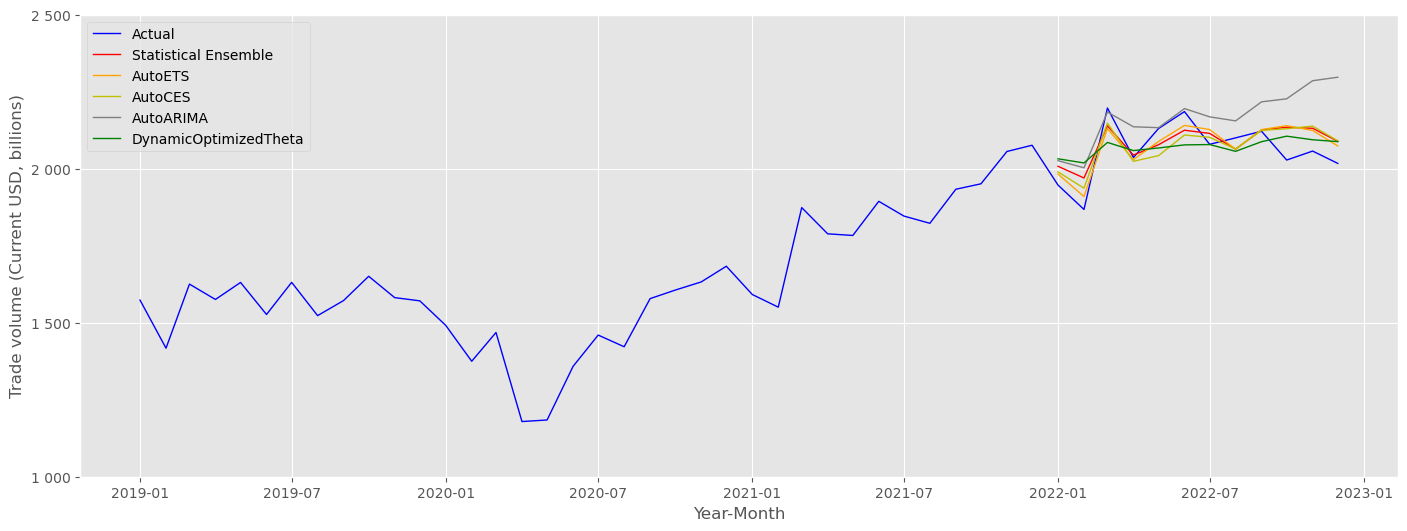

In [263]:
plt.style.use('ggplot')
plt.figure(figsize=(17, 6))
plt.plot(Y_df['ds'].tail(48), Y_df['y'].tail(48), linestyle='-', linewidth=1, color='b', label="Actual")
plt.plot(forecasts['ds'], forecasts['StatisticalEnsemble'], linestyle='-', linewidth=1, color='r', label="Statistical Ensemble")
plt.plot(forecasts['ds'], forecasts['AutoETS'], linestyle='-', linewidth=1, color='orange', label="AutoETS")
plt.plot(forecasts['ds'], forecasts['CES'], linestyle='-', linewidth=1, color='y', label="AutoCES")
plt.plot(forecasts['ds'], forecasts['AutoARIMA'], linestyle='-', linewidth=1, color='grey', label="AutoARIMA")
plt.plot(forecasts['ds'], forecasts['DynamicOptimizedTheta'], linestyle='-', linewidth=1, color='g', label="DynamicOptimizedTheta")
plt.xlabel("Year-Month", fontsize=12)
plt.ylabel("Trade volume (Current USD, billions)", fontsize=12)
plt.yticks(ticks=list(range(1000000, 3000000, 500000)), labels=["1 000", "1 500", "2 000", "2 500"])
plt.legend()

plt.show()

The vizualisation confirms our appreciation with the metrics : the Stastical ensemble is the best model.